In [1]:
import enum
import seaborn as sns
from data_handling.Data_Processor import DataProcessor
import constants
import os
from statistics_methods.Statistics import StatisticsWrapper
from statistics_methods.plots import PlotsManager
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

Constants

In [2]:
chosen_rois_dict = constants.ROI_CORTEX
params_to_work_with = constants.ALL_PARAMS

Load the data and proccess it

In [3]:
def load_data(data_path):
    subjects_raw_data = DataProcessor(data_path, chosen_rois_dict, chosen_rois_dict).get_data_proccessed()
    analyzed_data = StatisticsWrapper.calc_mean_per_subject_per_parameter_per_ROI(subjects_raw_data, params_to_work_with)
    chosen_data = StatisticsWrapper.chose_relevant_data(analyzed_data, chosen_rois_dict, params_to_work_with, params_to_work_with)

    group_a_name, group_b_name, col_divider, threshold = constants.YOUNG, constants.OLD, 'Age', constants.AGE_THRESHOLD
    young_subjects, old_subjects = StatisticsWrapper.seperate_data_to_two_groups(chosen_data, col_divider, threshold)

    return chosen_data, young_subjects, old_subjects

In [4]:
chosen_data_raw, young_subjects_raw, old_subjects_raw = load_data(constants.PATH_TO_CORTEX_all_params_raw)
chosen_data_z_score, young_subjects_z_score, old_subjects_z_score = load_data(constants.PATH_TO_CORTEX_all_params_z_score)

Check raw data variations

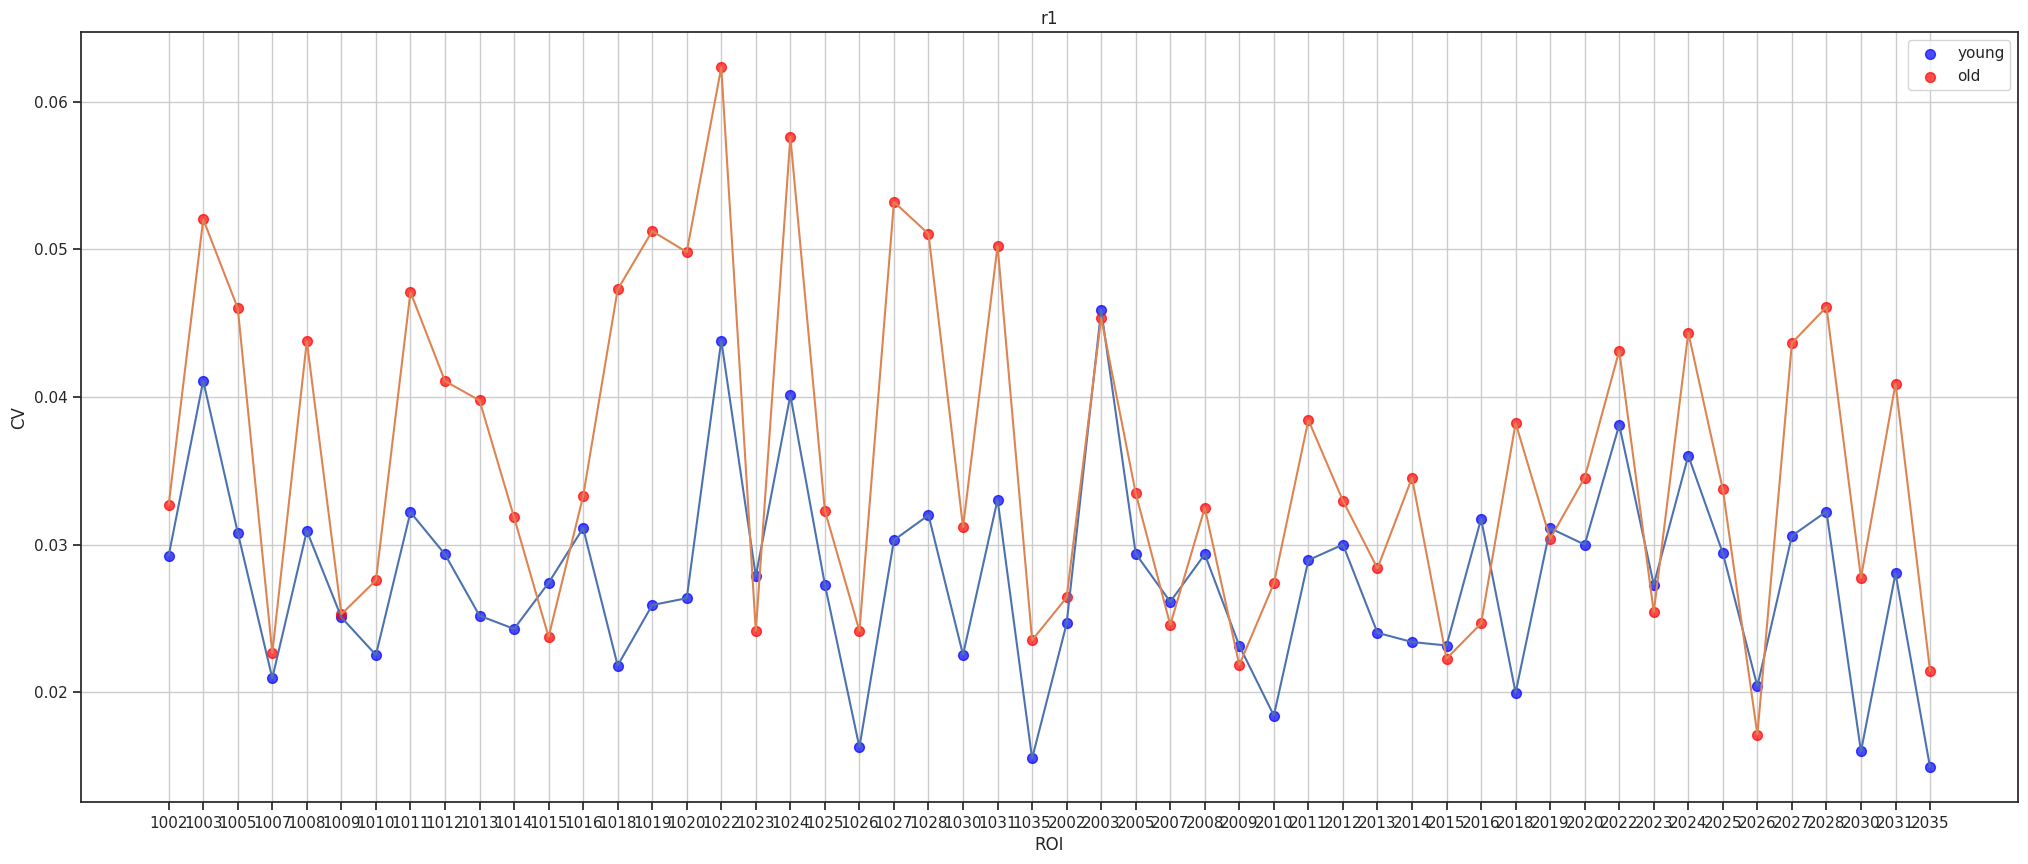

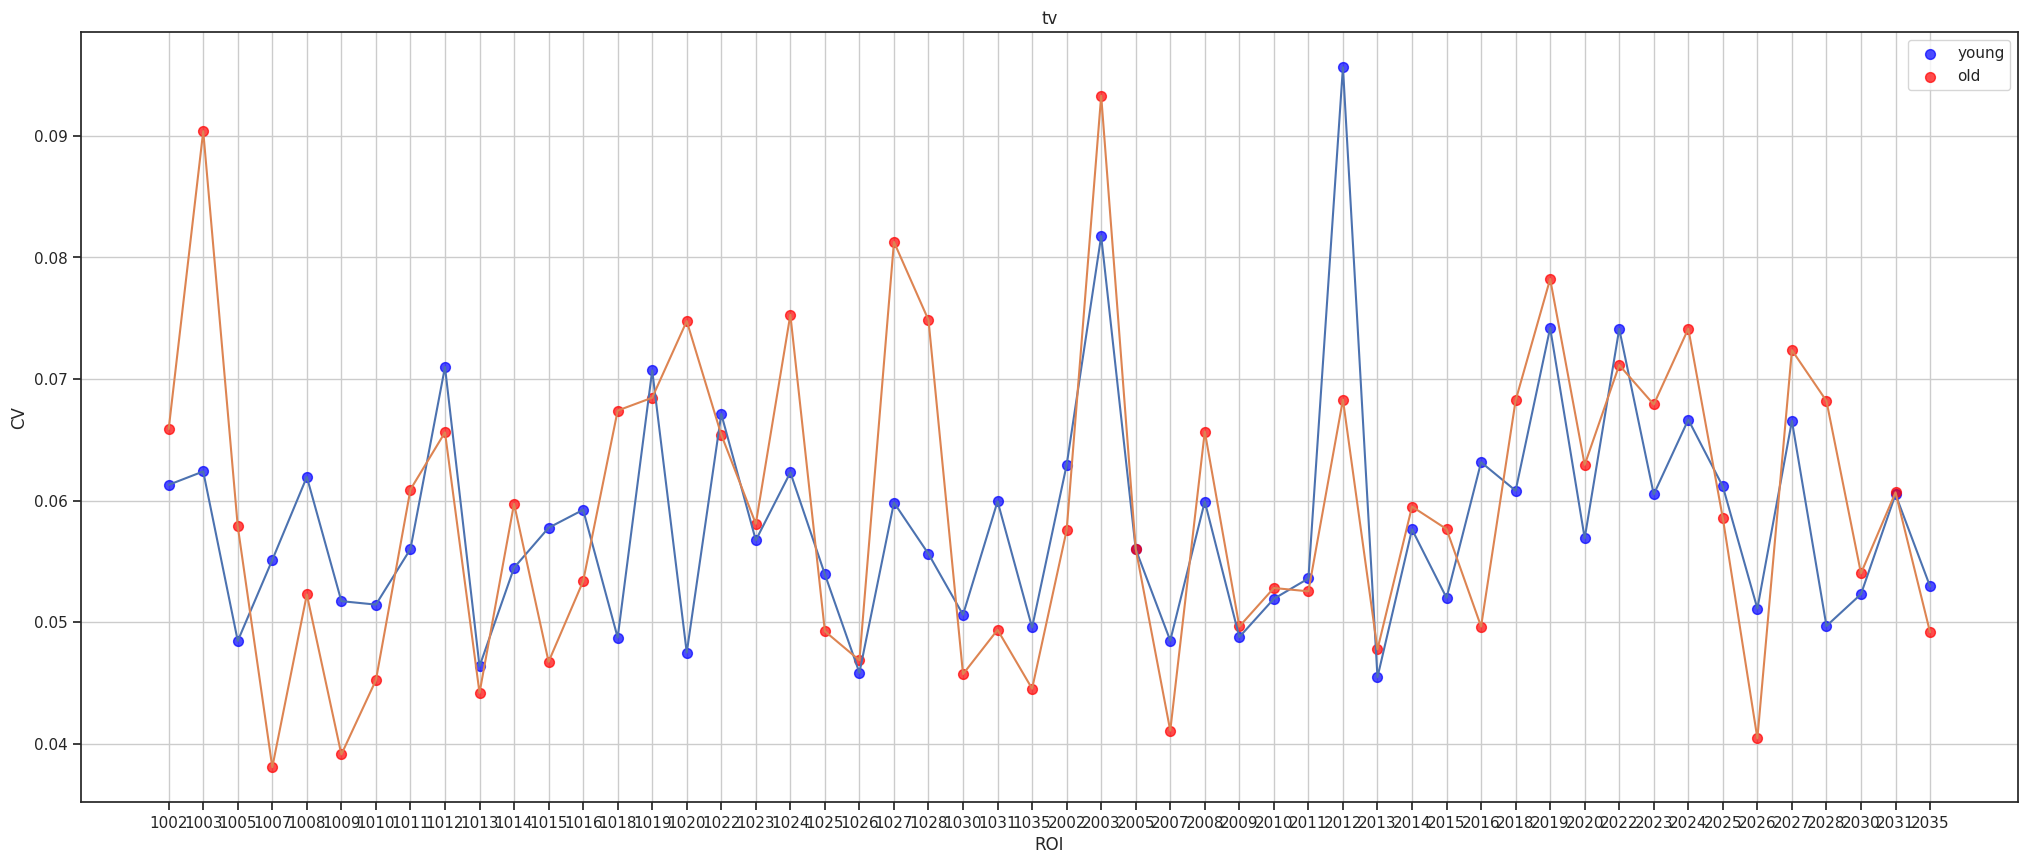

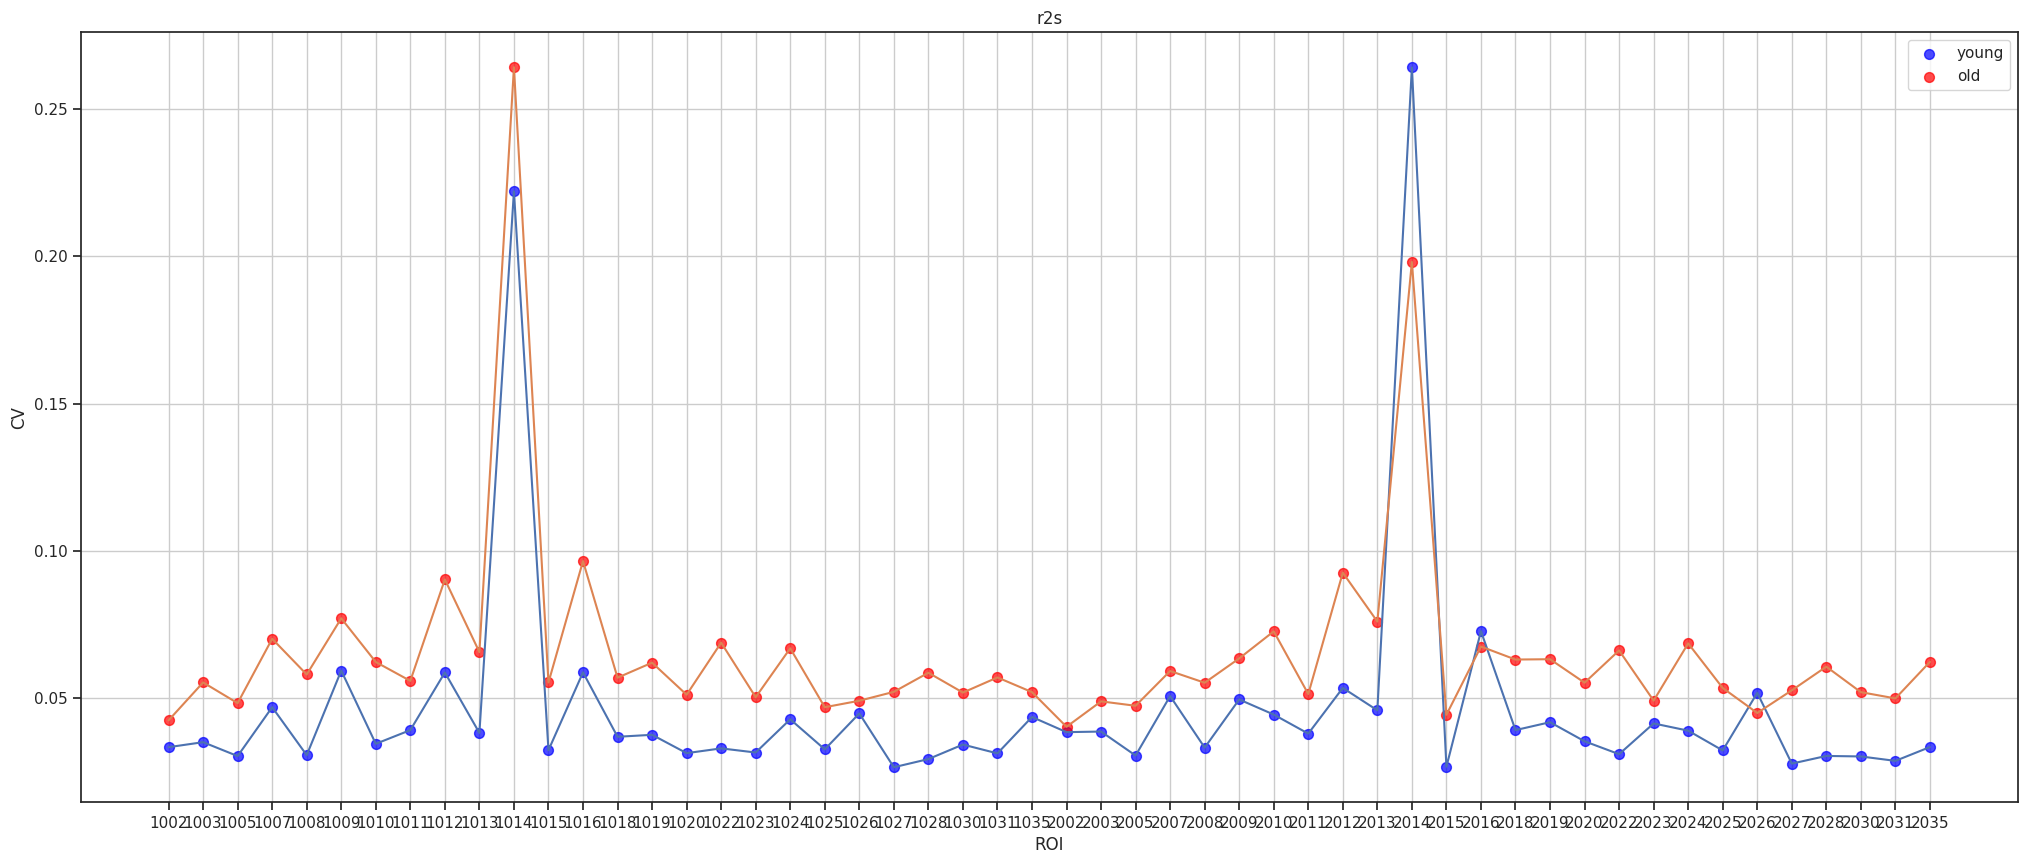

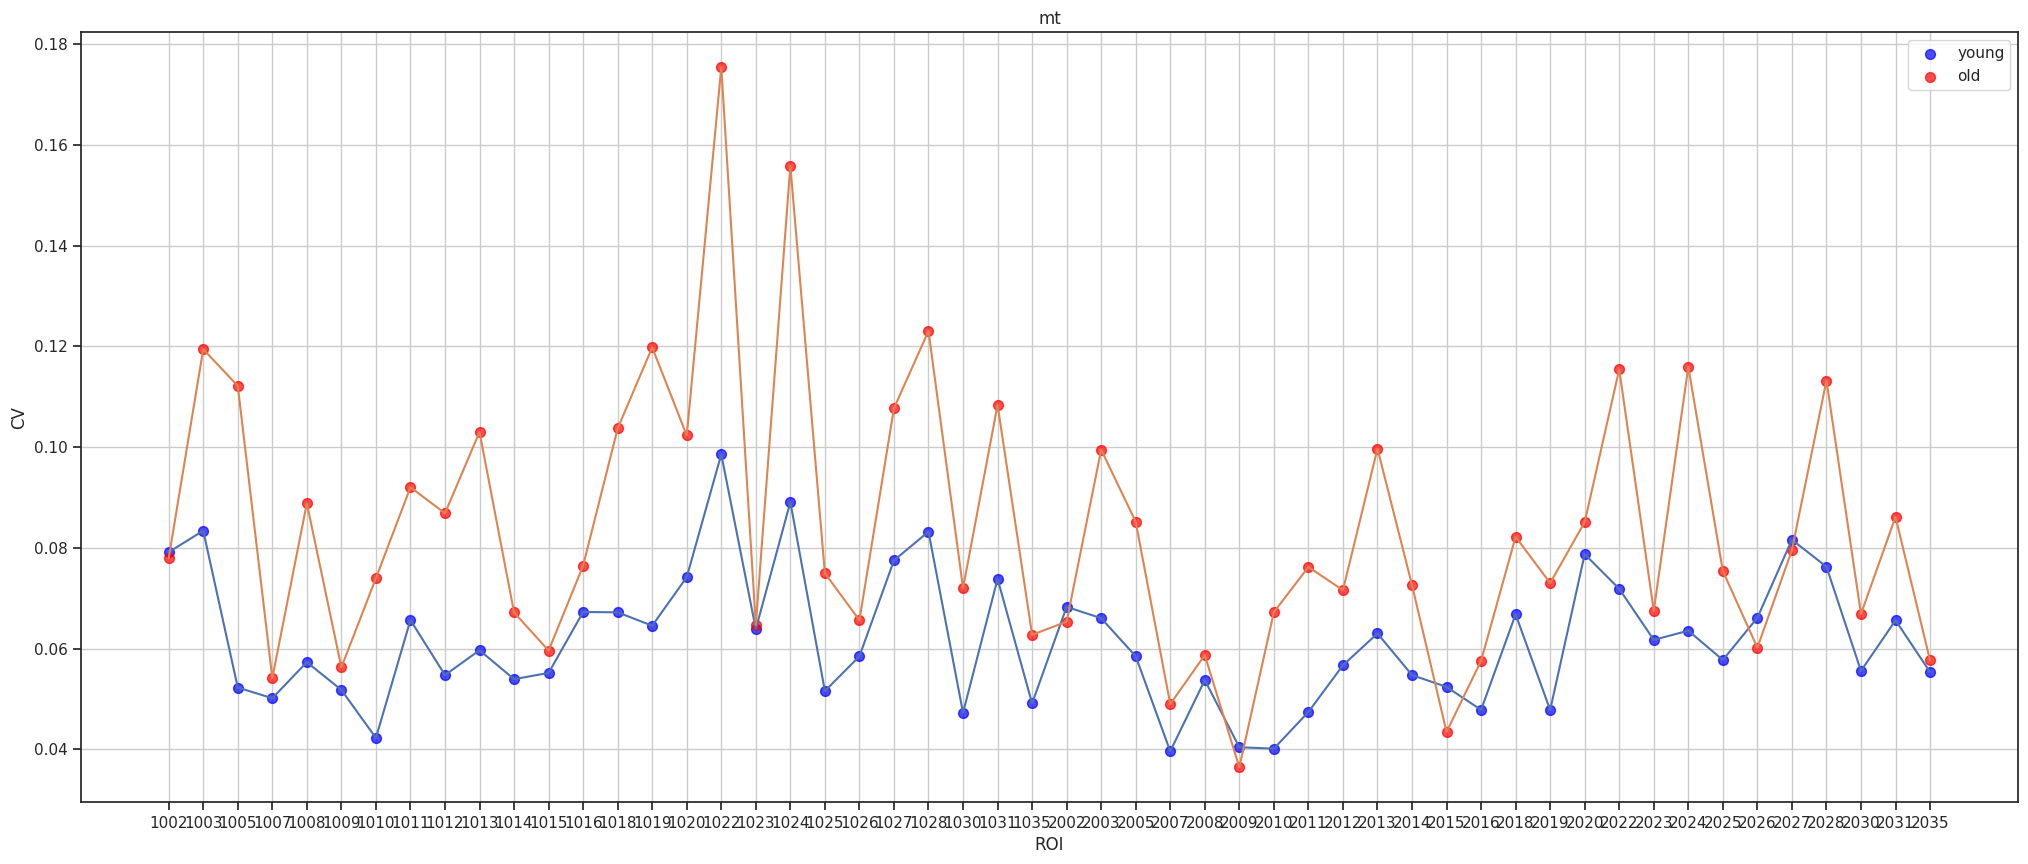

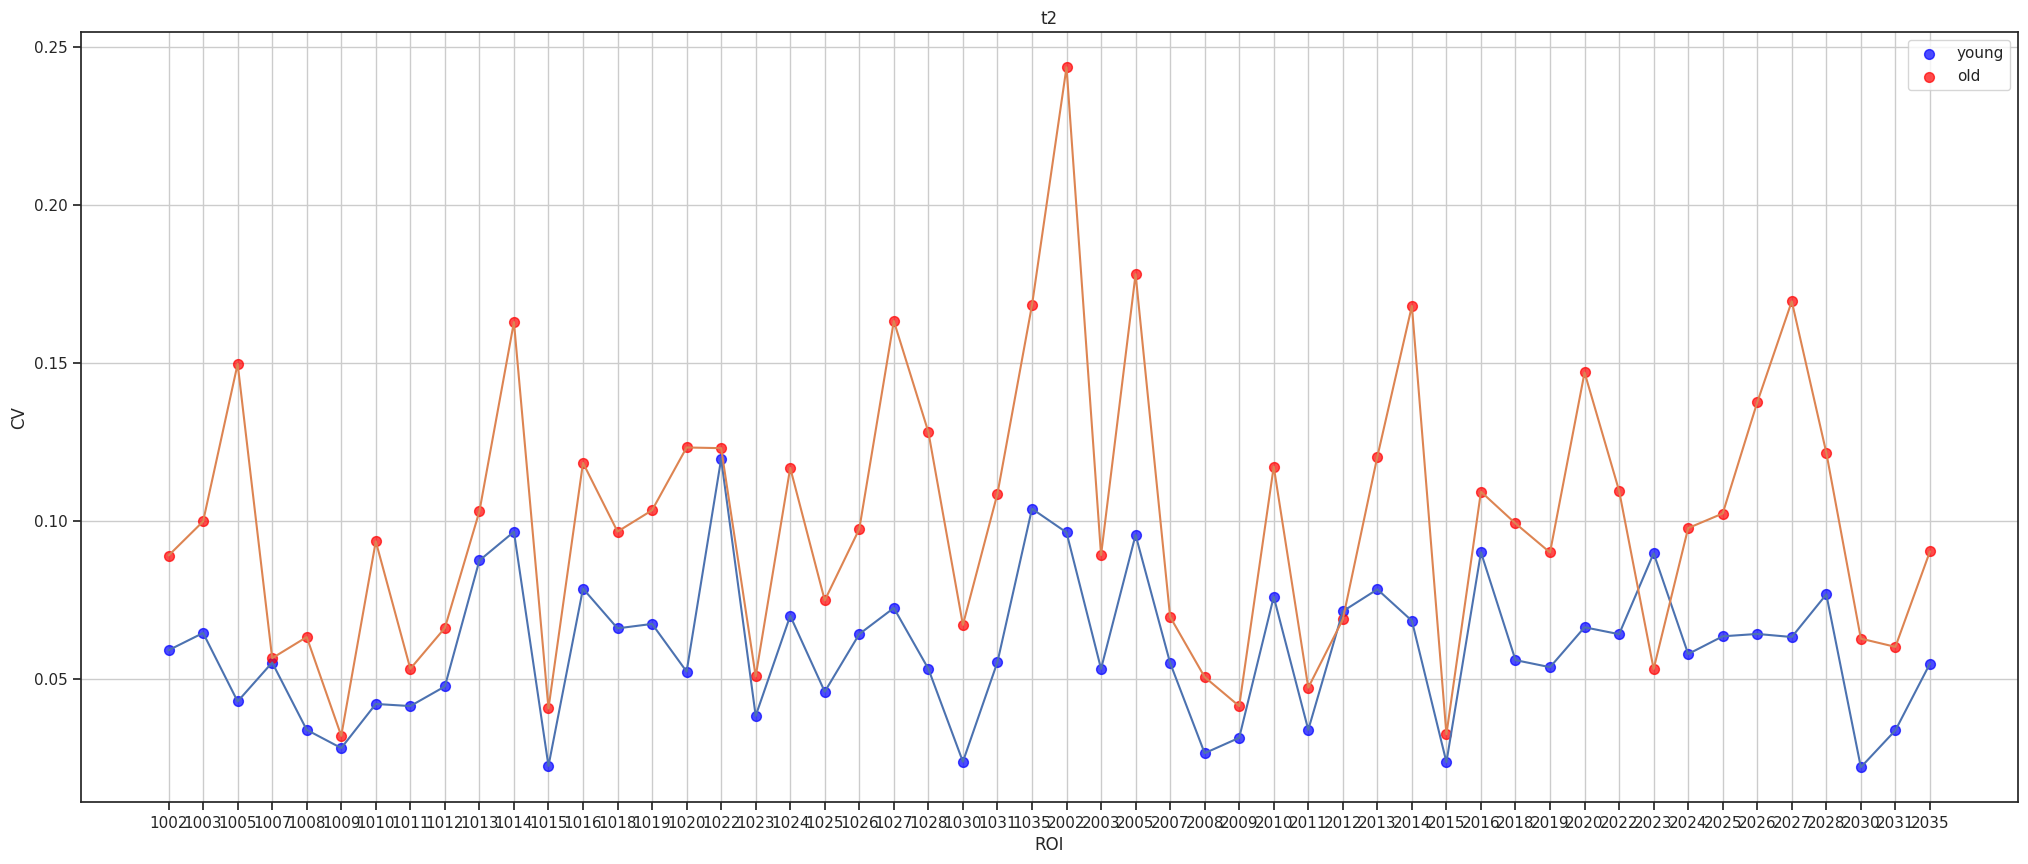

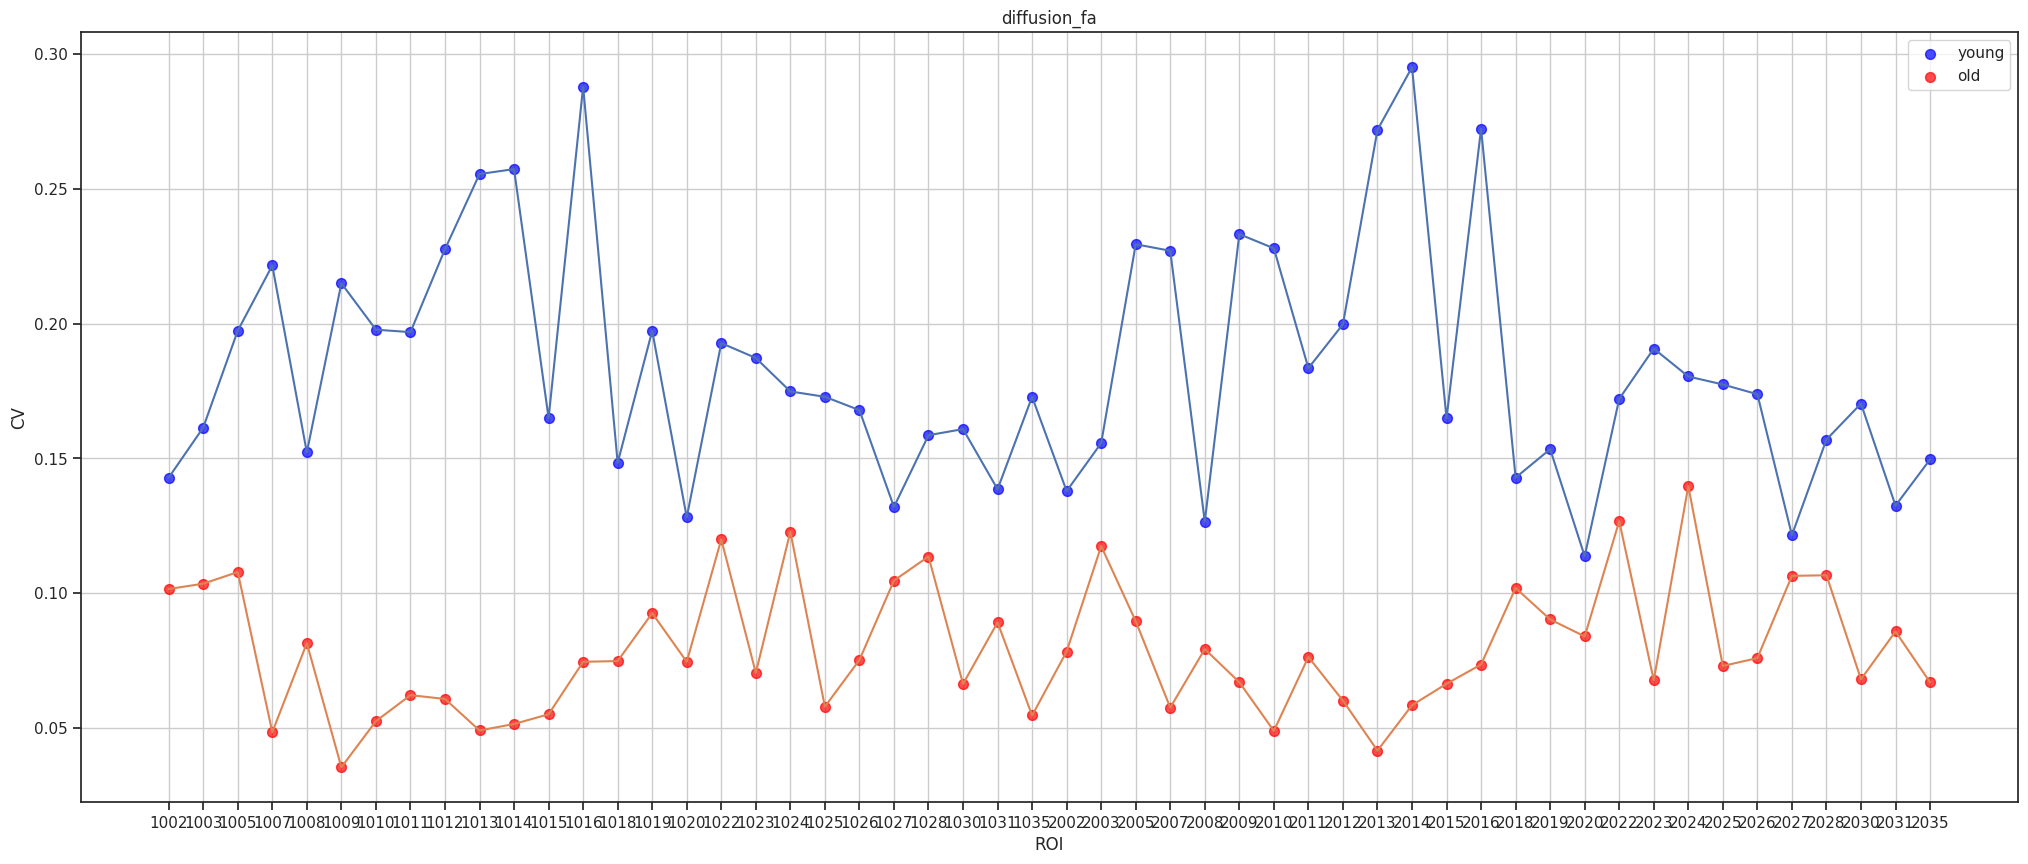

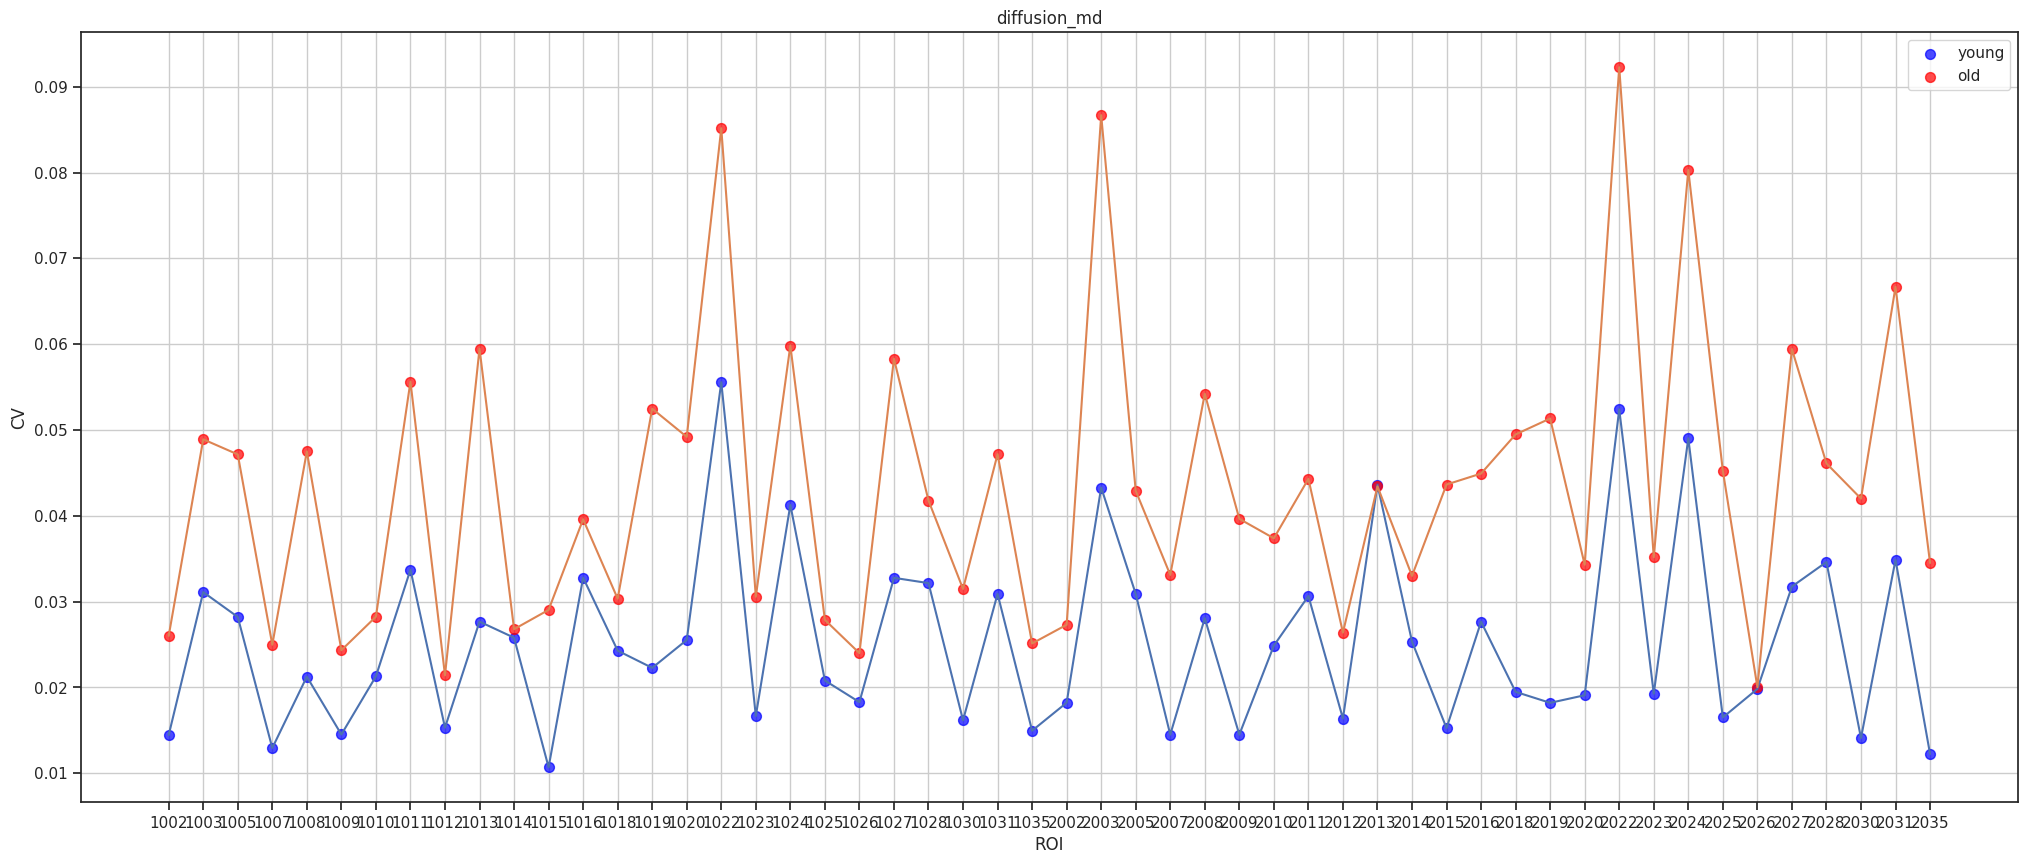

In [5]:
group_by_param = 'ROI'
x_axis = 'ROI'
data_groups = [(young_subjects_raw, 'blue', 'young'), (old_subjects_raw, 'red', 'old')]
StatisticsWrapper.calculate_cv_for_subjects(data_groups, group_by_param, params_to_work_with, x_axis, use_reg=False, fig_size=(25, 10), connect_scatter=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


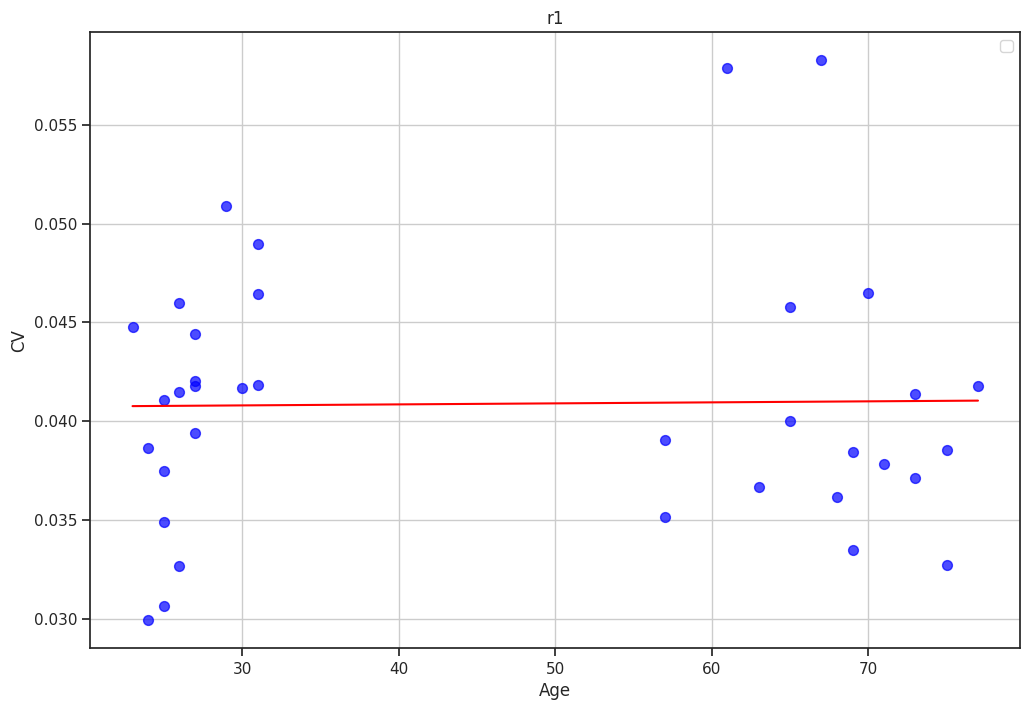

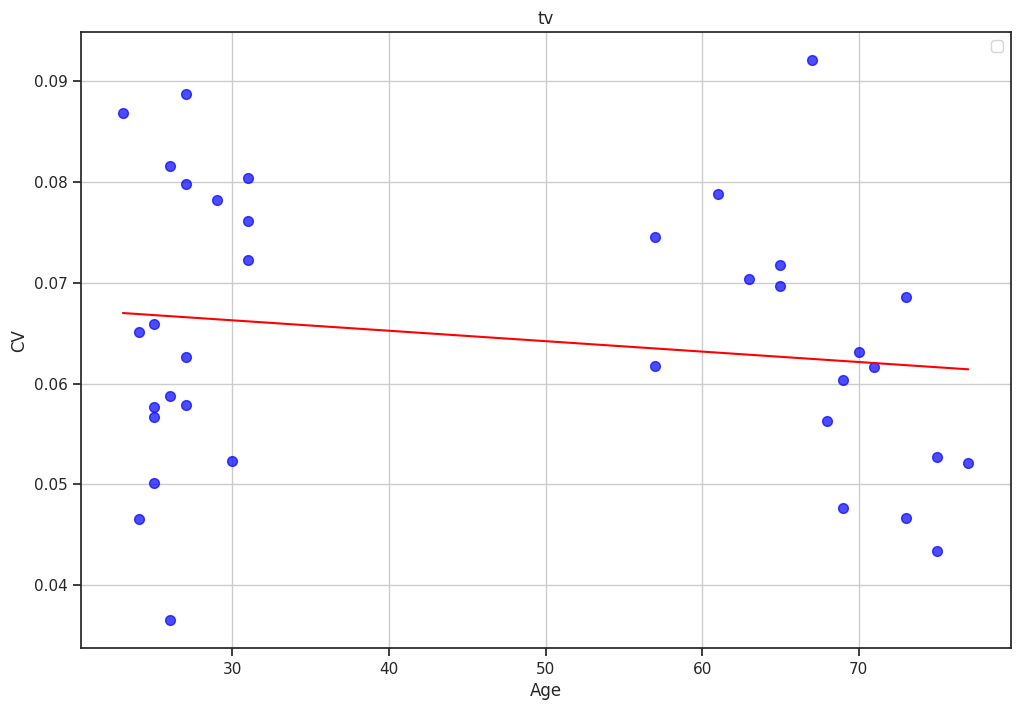

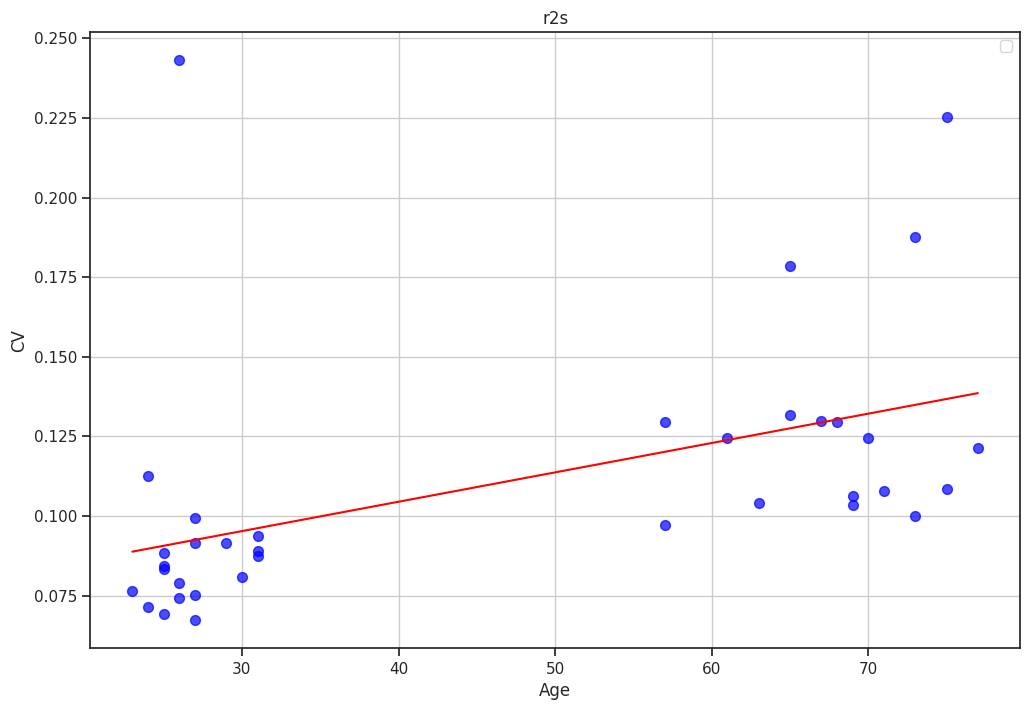

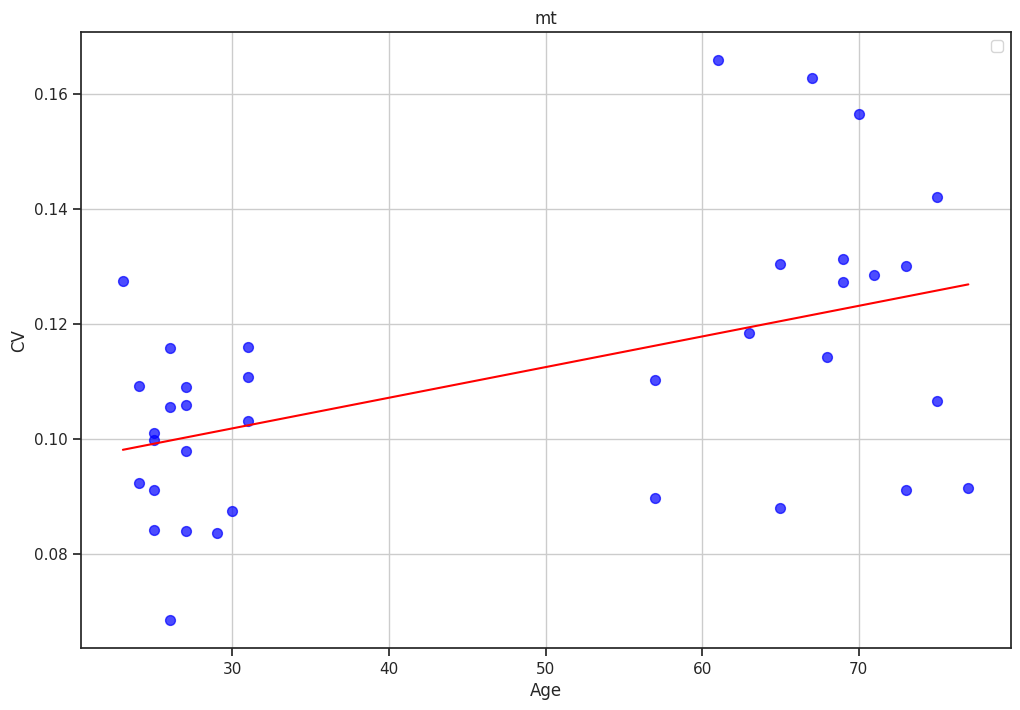

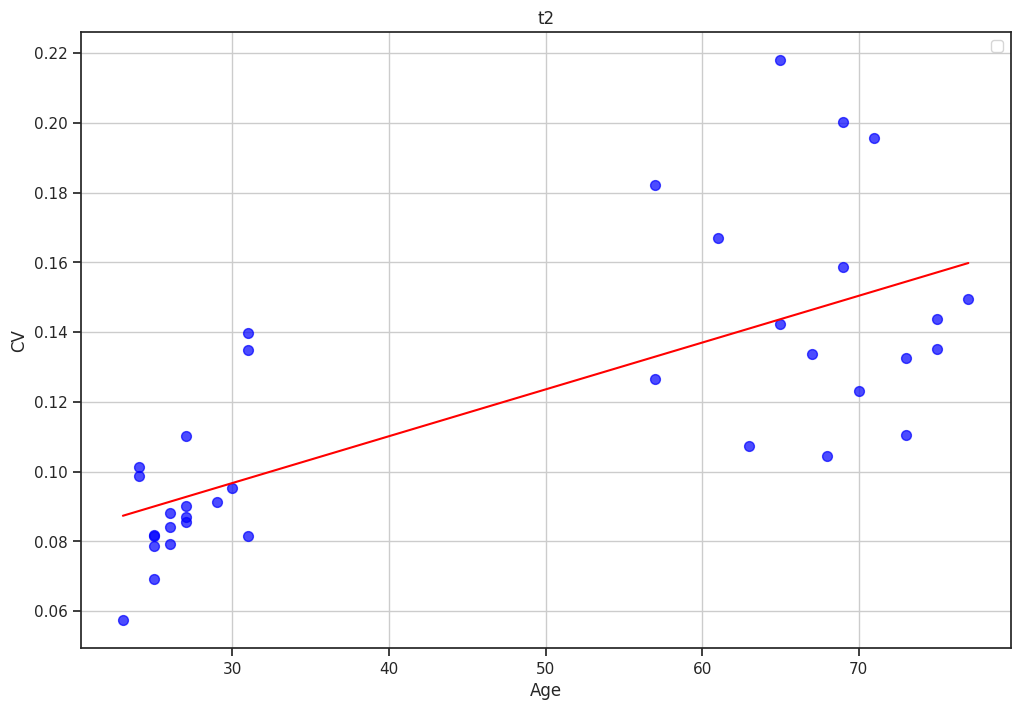

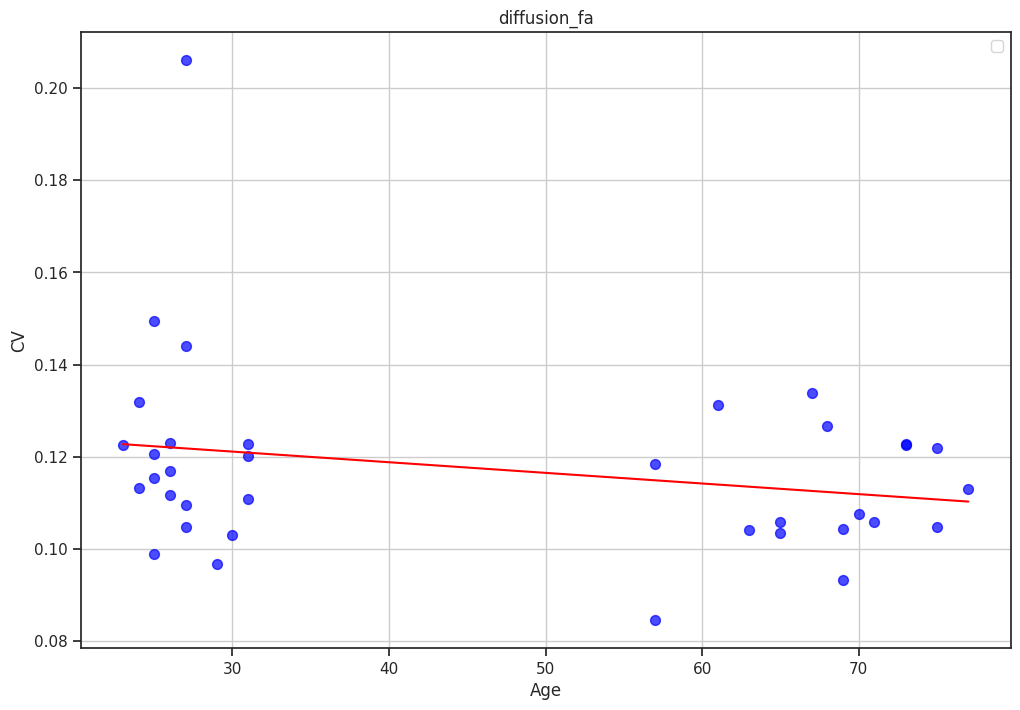

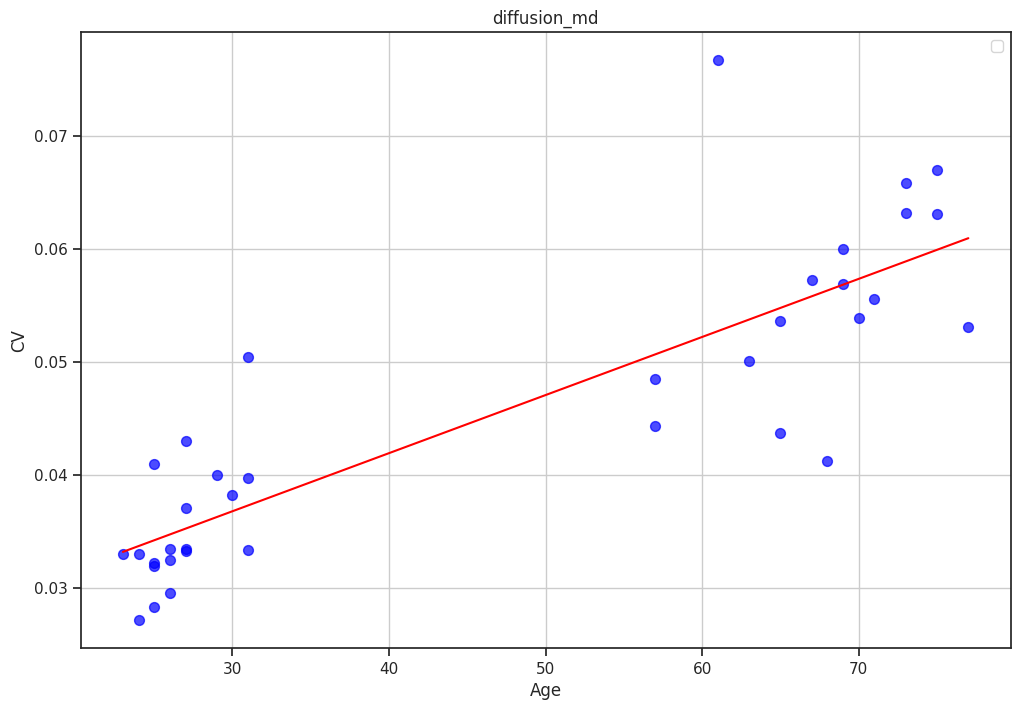

In [7]:
group_by_param = 'subjects'
x_axis = 'Age'
data_groups = [(chosen_data_raw, 'blue', '')]
StatisticsWrapper.calculate_cv_for_subjects(data_groups, group_by_param, params_to_work_with, x_axis, use_reg=True, fig_size=(12, 8))

Check correlations on the normalized data

In [5]:
def show_correlations_stats(all_data, young_data, old_data, method):
    clusters_rois = StatisticsWrapper.hierarchical_clustering(all_data, params_to_work_with, 'single',
                                                                title="all")['dendrogram_data']['ivl']
    young_result = StatisticsWrapper.roi_correlations(young_data, params_to_work_with, clusters_rois,
                                                        'young', method=method)
    old_result = StatisticsWrapper.roi_correlations(old_data, params_to_work_with, clusters_rois, 'old', method=method)

    PlotsManager.plot_heatmap(old_result - young_result, 'differences of old and young', project_name=None)

    young_result['corr_mean'] = young_result.apply(np.mean, axis=1) - 1/young_result.shape[0]
    old_result['corr_mean'] = old_result.apply(np.mean, axis=1) - 1/old_result.shape[0]

    plt.figure(figsize=(12, 8))  # Adjust figure size as needed
    plt.scatter(chosen_rois_dict.values(), young_result['corr_mean'].to_numpy(), color='blue', s=20, alpha=0.7, label='young')
    plt.scatter(chosen_rois_dict.values(), old_result['corr_mean'].to_numpy(), color='red', s=20, alpha=0.7, label='old')
    plt.plot(chosen_rois_dict.values(), young_result['corr_mean'].to_numpy())
    plt.plot(chosen_rois_dict.values(), old_result['corr_mean'].to_numpy())
    plt.legend()
    plt.grid(False)


/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code/statistics_methods/Statistics.py:529: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters = linkage(distances, method=linkage_metric)


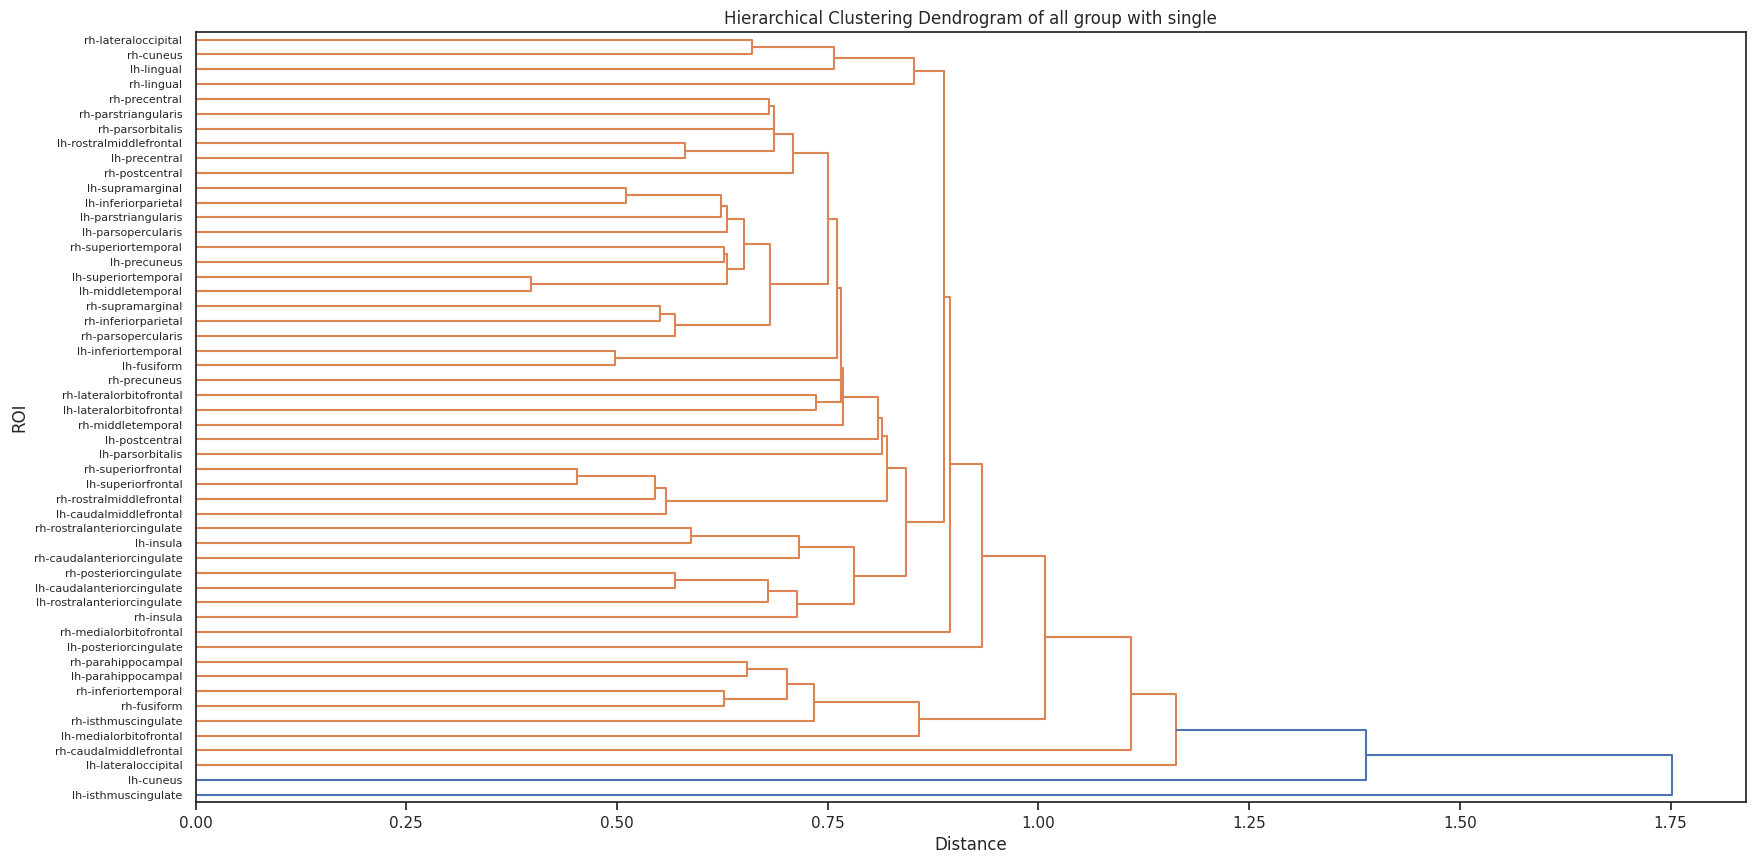

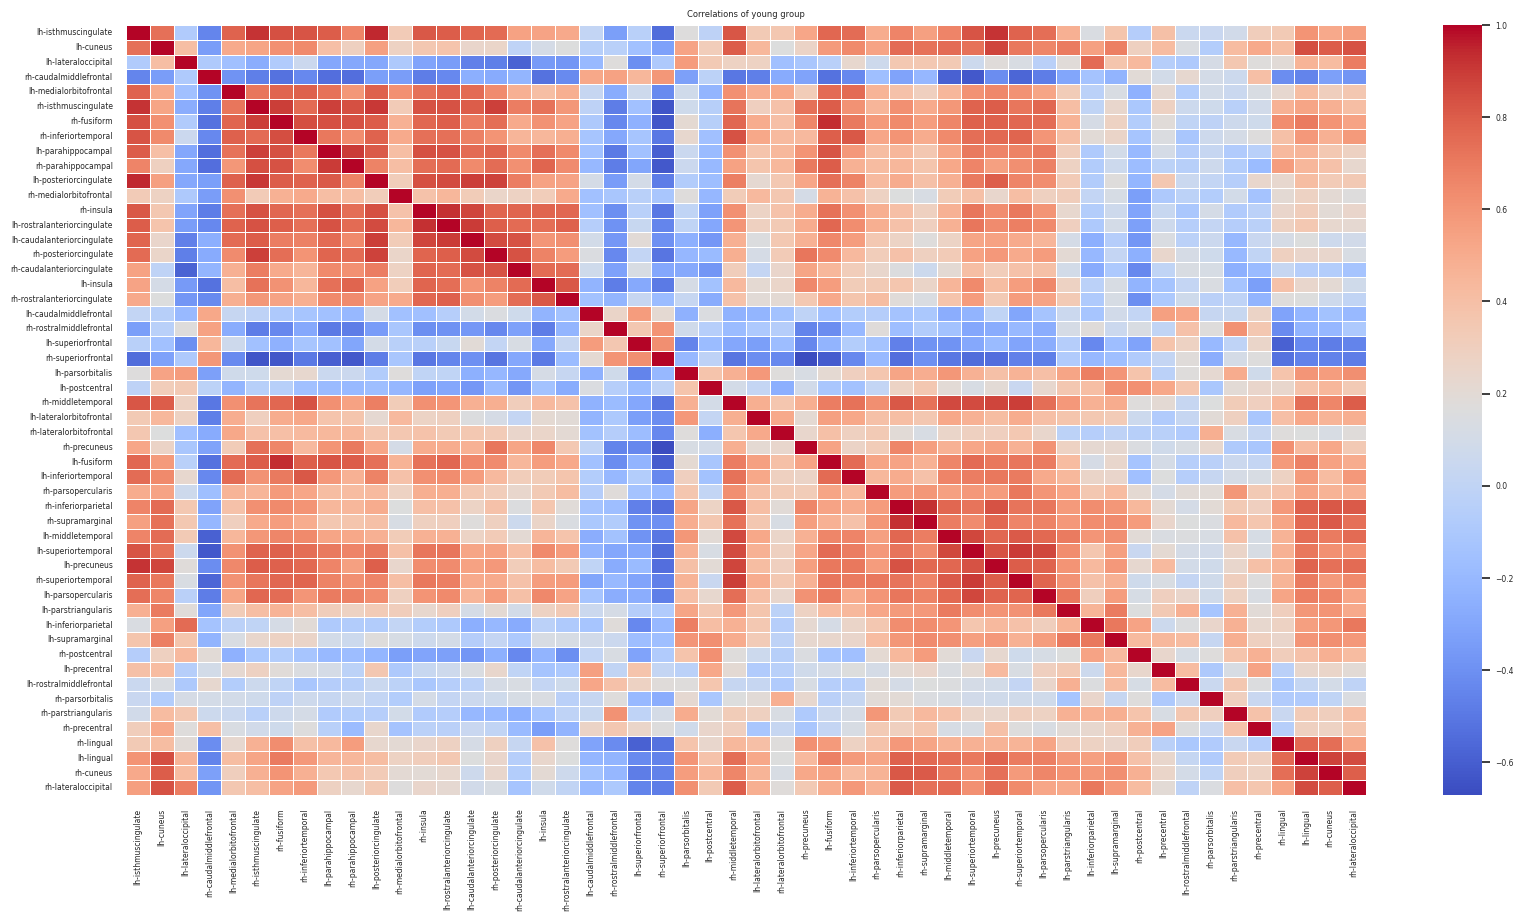

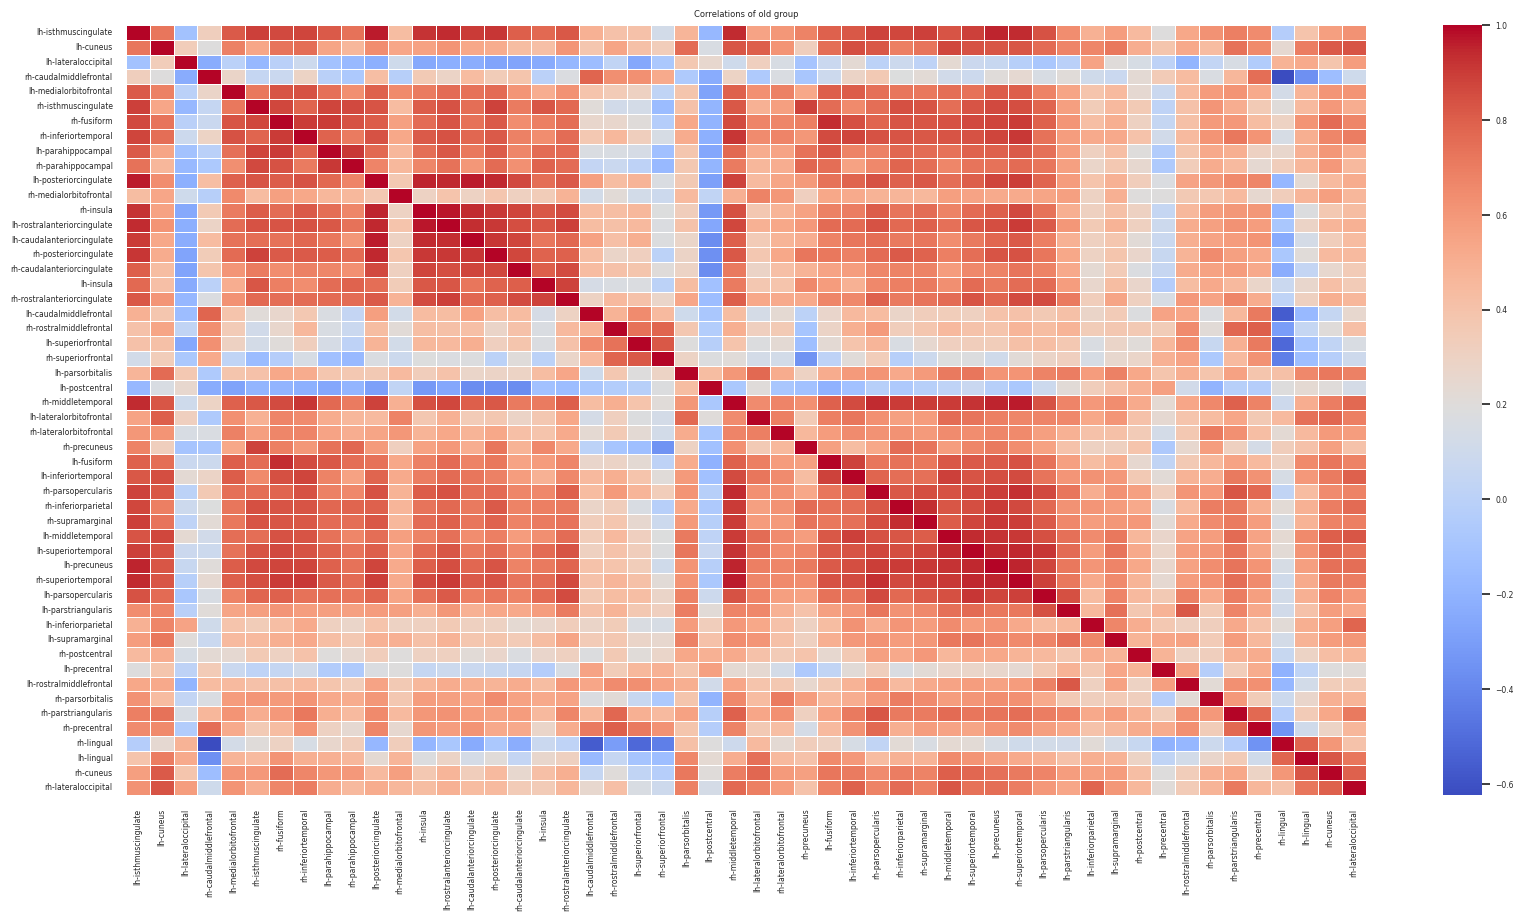

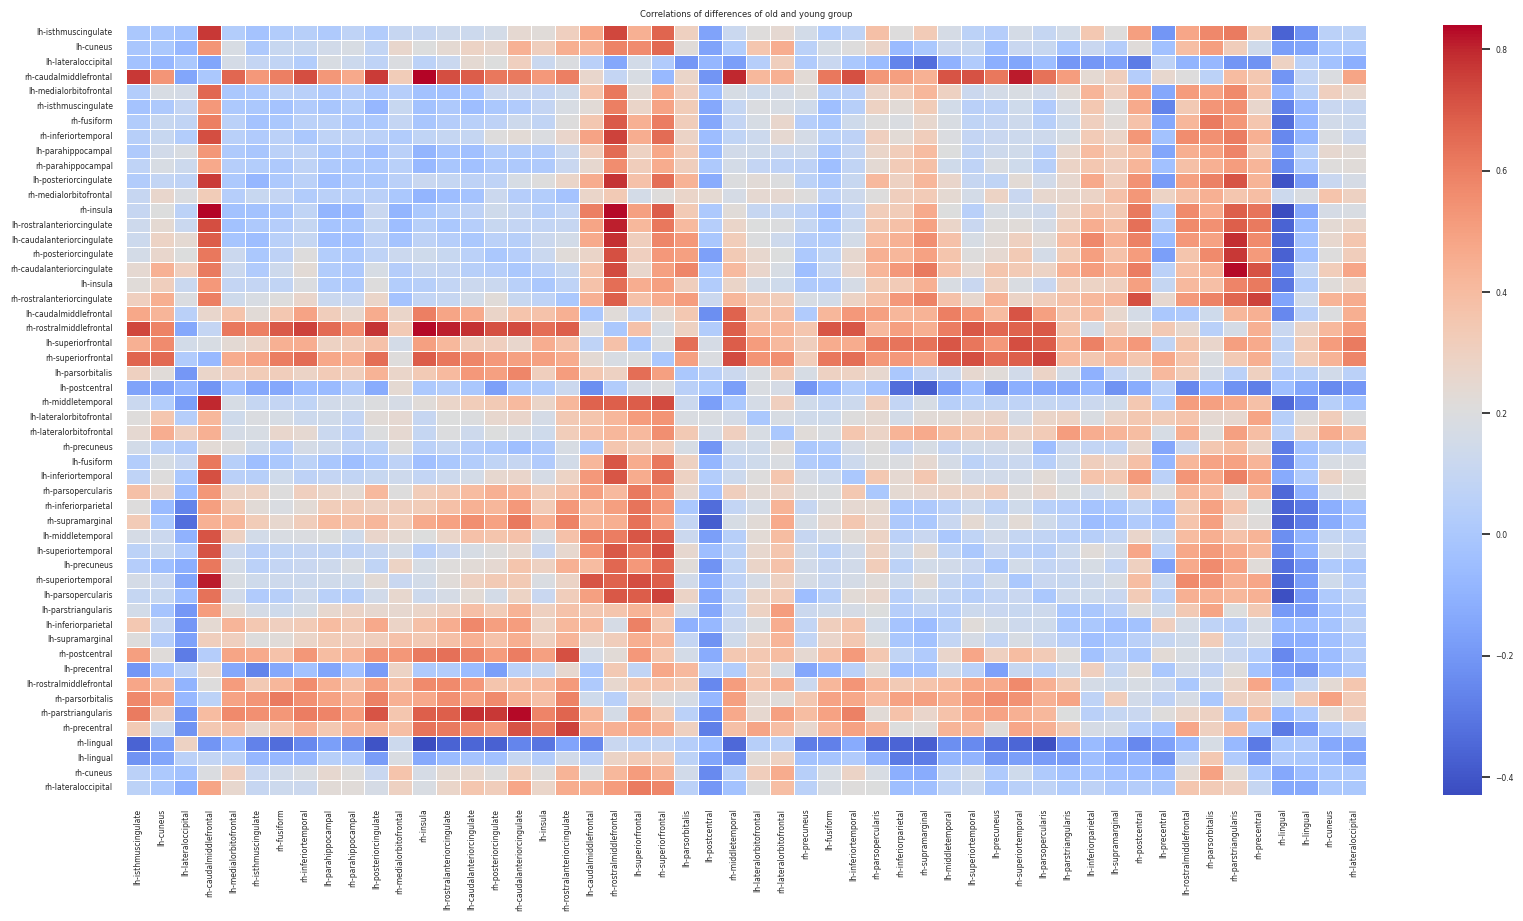

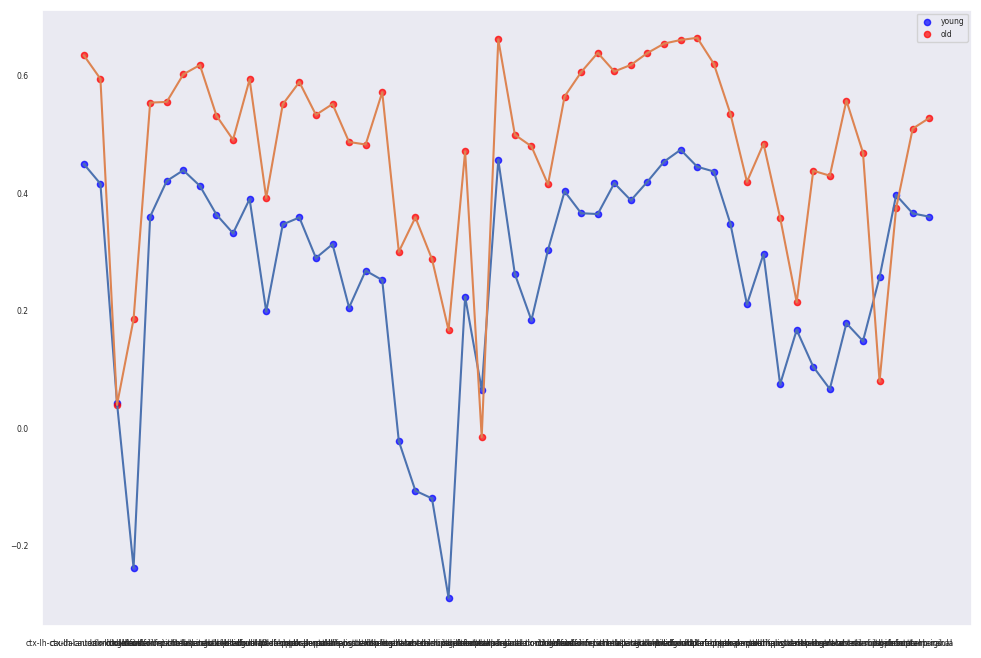

In [6]:
show_correlations_stats(chosen_data_z_score, young_subjects_z_score, old_subjects_z_score, 'pearson')

/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code/statistics_methods/Statistics.py:529: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters = linkage(distances, method=linkage_metric)


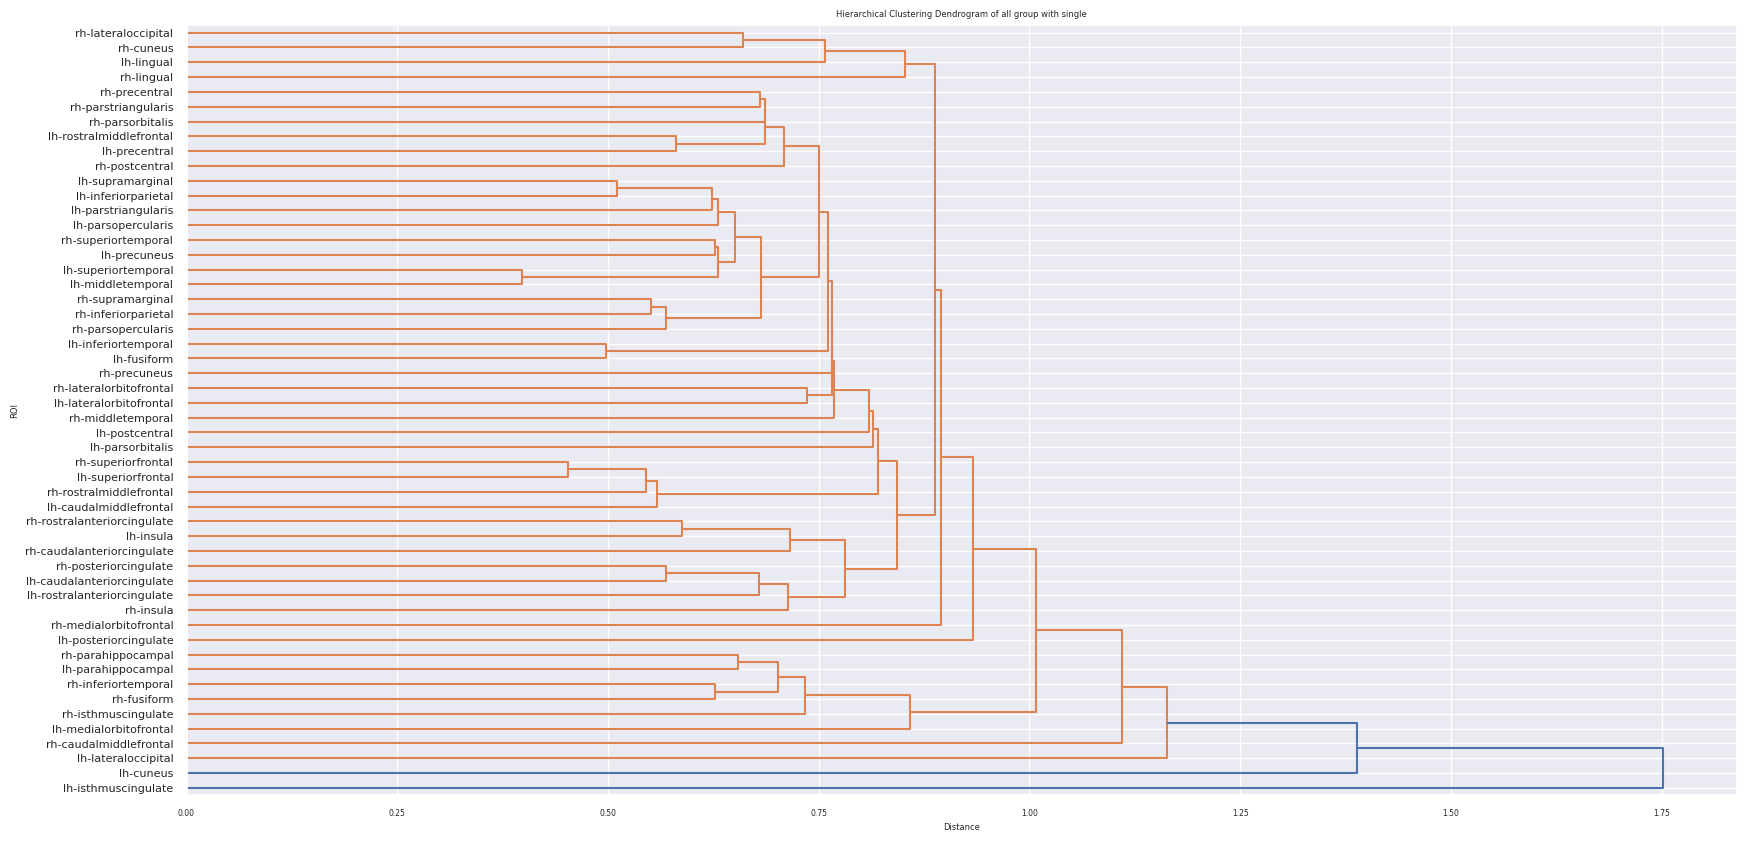

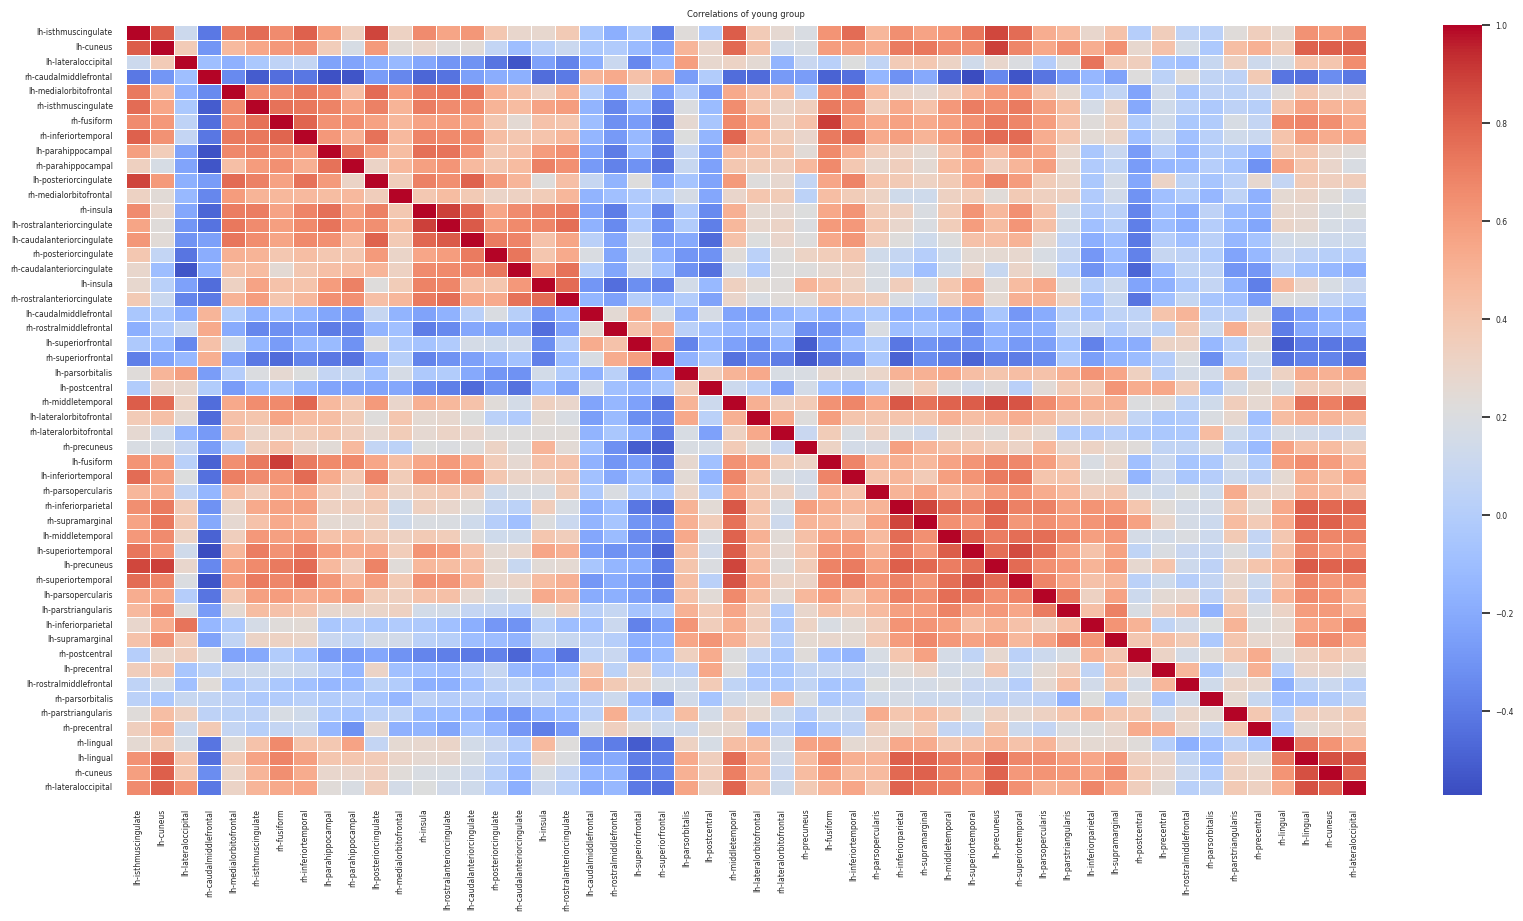

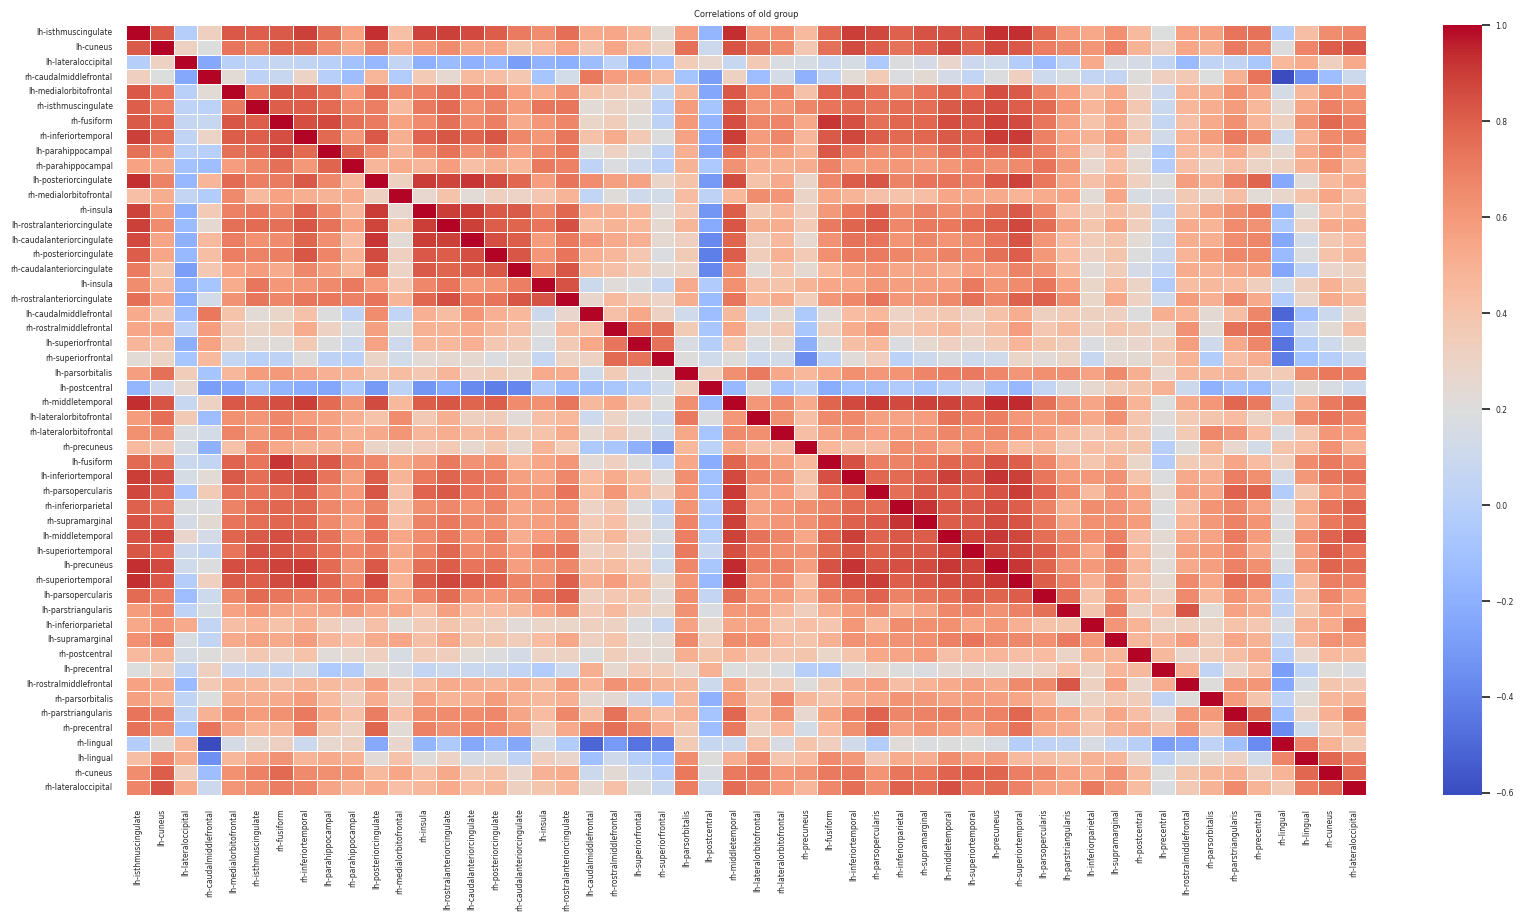

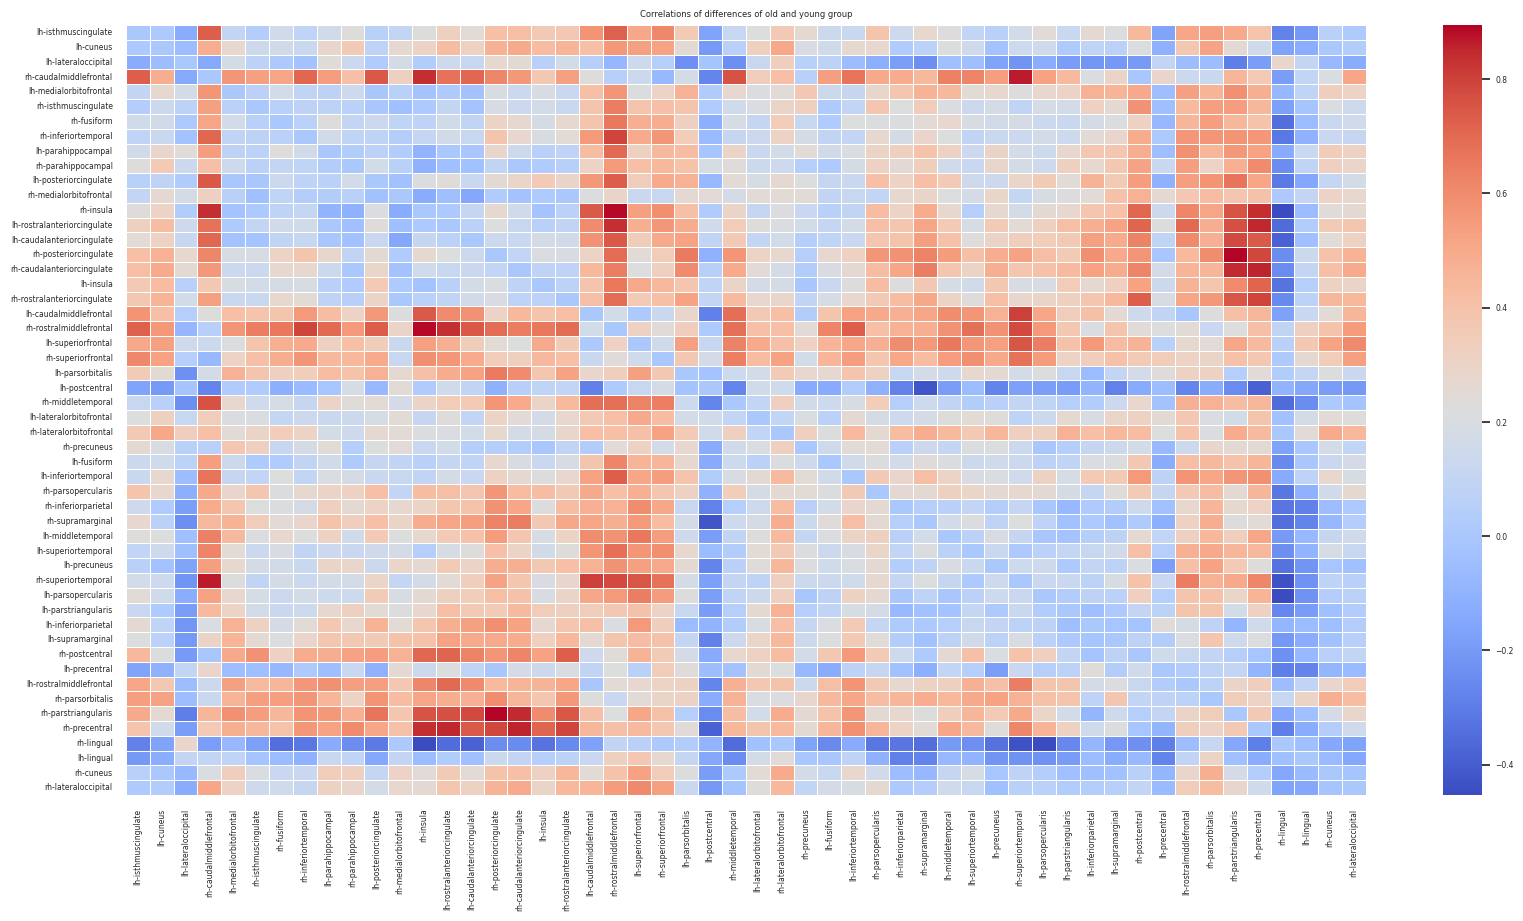

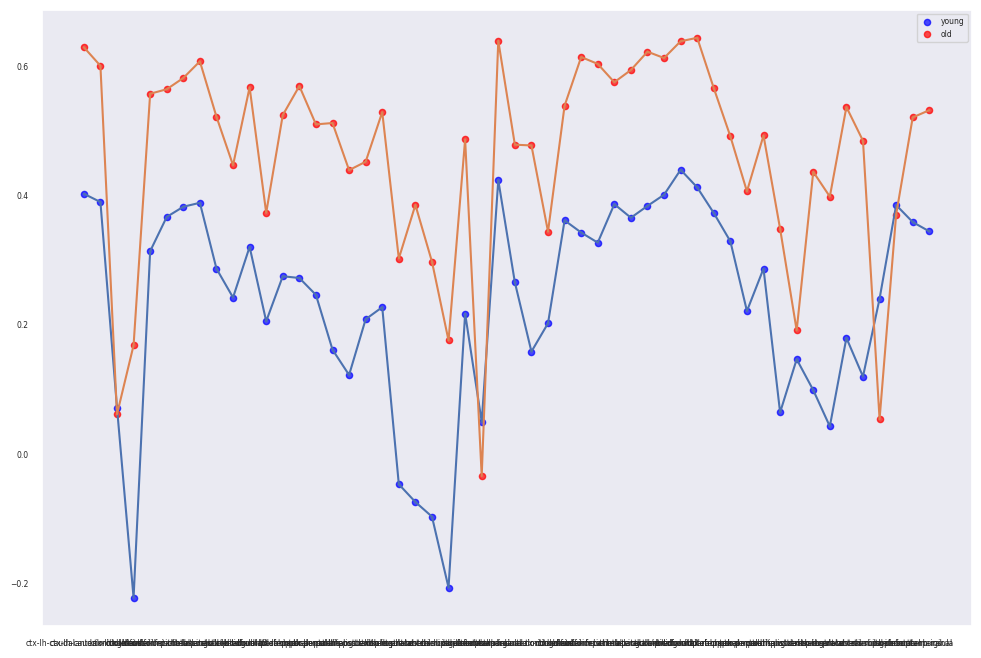

In [7]:
plt.close()
show_correlations_stats(chosen_data_z_score, young_subjects_z_score, old_subjects_z_score, 'spearman')

Check t_test on the young and old groups

In [5]:
StatisticsWrapper.t_test_per_parameter_per_area(young_subjects_z_score, old_subjects_z_score, chosen_rois_dict, 'ROI', params_to_work_with)

param r1 number of areas with significance differences: 38
param tv number of areas with significance differences: 20
param r2s number of areas with significance differences: 20
param mt number of areas with significance differences: 26
param t2 number of areas with significance differences: 30
param diffusion_fa number of areas with significance differences: 22
param diffusion_md number of areas with significance differences: 26


In [101]:
def reduce_dim(model, data, num_of_dim):
    res = model.fit_transform(data)

    column_names = [f"var_{i + 1}" for i in range(num_of_dim)]  # Generate dynamic column names
    reduced_data = pd.DataFrame(res, columns=column_names)

    return reduced_data

In [188]:
young_features_df = pd.pivot_table(young_subjects, index='subjects', columns='ROI', values=params_to_work_with, aggfunc='sum')
old_features_df = pd.pivot_table(old_subjects, index='subjects', columns='ROI', values=params_to_work_with, aggfunc='sum')

In [189]:
dim = 2
model = TSNE(n_components=dim, perplexity=5, random_state=42)
# model = PCA(n_components=2)
young_df_reduced = reduce_dim(model, young_features_df, dim)
old_df_reduced = reduce_dim(model, old_features_df, dim)

<AxesSubplot: xlabel='var_1', ylabel='var_2'>

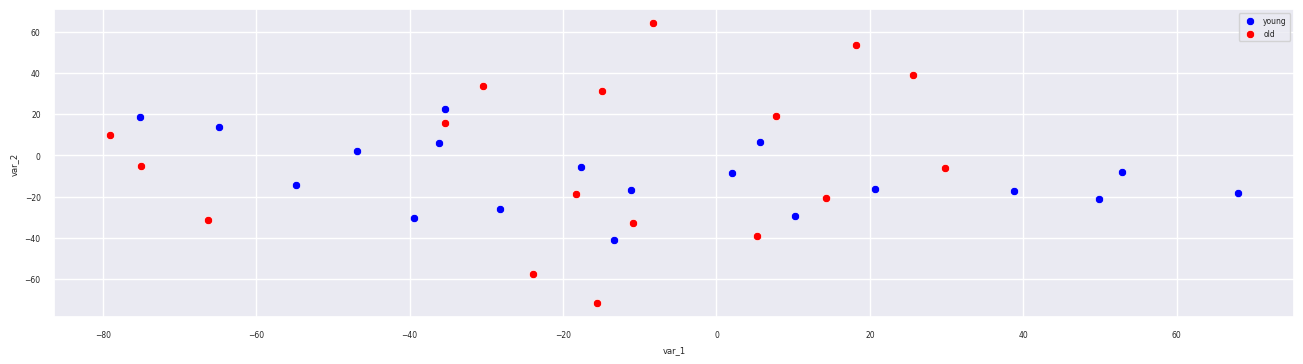

In [185]:
fig = plt.figure(figsize=(16,4))
# ax = fig.add_subplot(projection='3d')
# ax1 = plt.subplot(1, 3, 1)
# ax2 = plt.subplot(1, 3, 2)
# ax.scatter(young_df_reduced['var_1'], young_df_reduced['var_2'], young_df_reduced['var_3'], color='blue')
# ax.scatter(old_df_reduced['var_1'], old_df_reduced['var_2'], old_df_reduced['var_3'], color='red')
sns.scatterplot(
    x="var_1", y="var_2",
    hue=young_subjects,
    palette=sns.color_palette("hls", 10),
    # color='blue',
    data=young_df_reduced,
    legend="full",
    label="young"
    # ax=ax
)

# sns.scatterplot(
#     x="var_1", y="var_2",
#     # hue="y",
#     # palette=sns.color_palette("hls", 10),
#     color='red',
#     data=old_df_reduced,
#     legend="full",
#     label="old"
#     # ax=ax
# )

In [145]:
columns_to_keep = params_to_work_with + ['ROI']
young_features_df = young_subjects[columns_to_keep]
old_features_df = old_subjects[columns_to_keep]

young_features_df.index = young_subjects.subjects
old_features_df.index = old_subjects.subjects

In [164]:
model = TSNE(n_components=2, perplexity=10, random_state=42)
# model = PCA(n_components=2)
young_df_reduced = reduce_dim(model, young_features_df, 2)
old_df_reduced = reduce_dim(model, old_features_df, 2)

<AxesSubplot: xlabel='var_1', ylabel='var_2'>

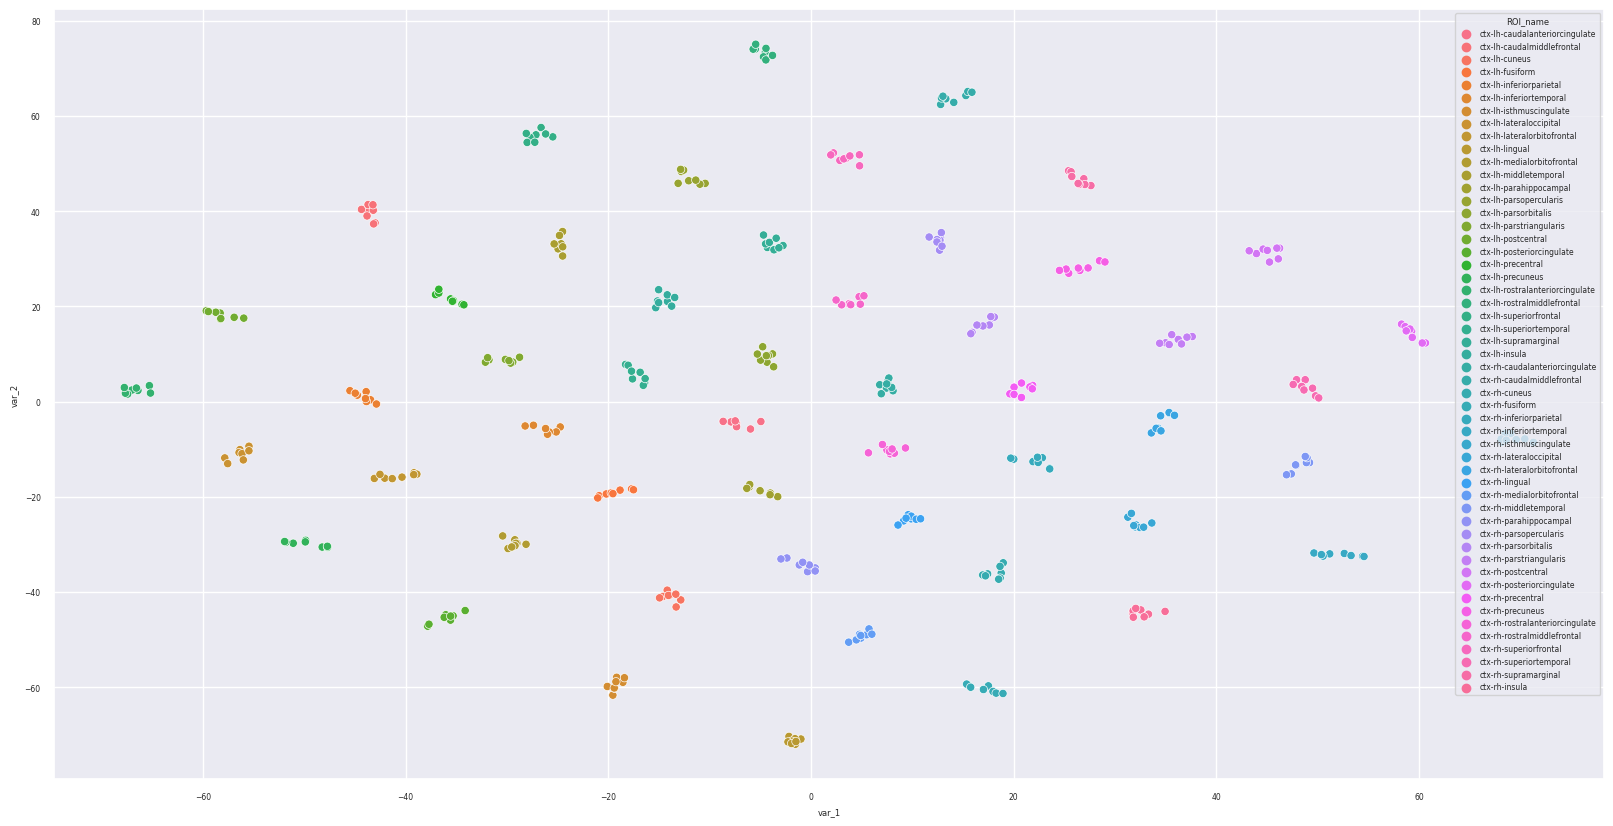

In [175]:
fig = plt.figure(figsize=(20,10))

sns.scatterplot(
    x="var_1", y="var_2",
    hue=young_subjects['ROI_name'],
    palette=sns.color_palette("husl", 52),
    color='blue',
    data=young_df_reduced,
    legend="full",
    )

<AxesSubplot: xlabel='var_1', ylabel='var_2'>

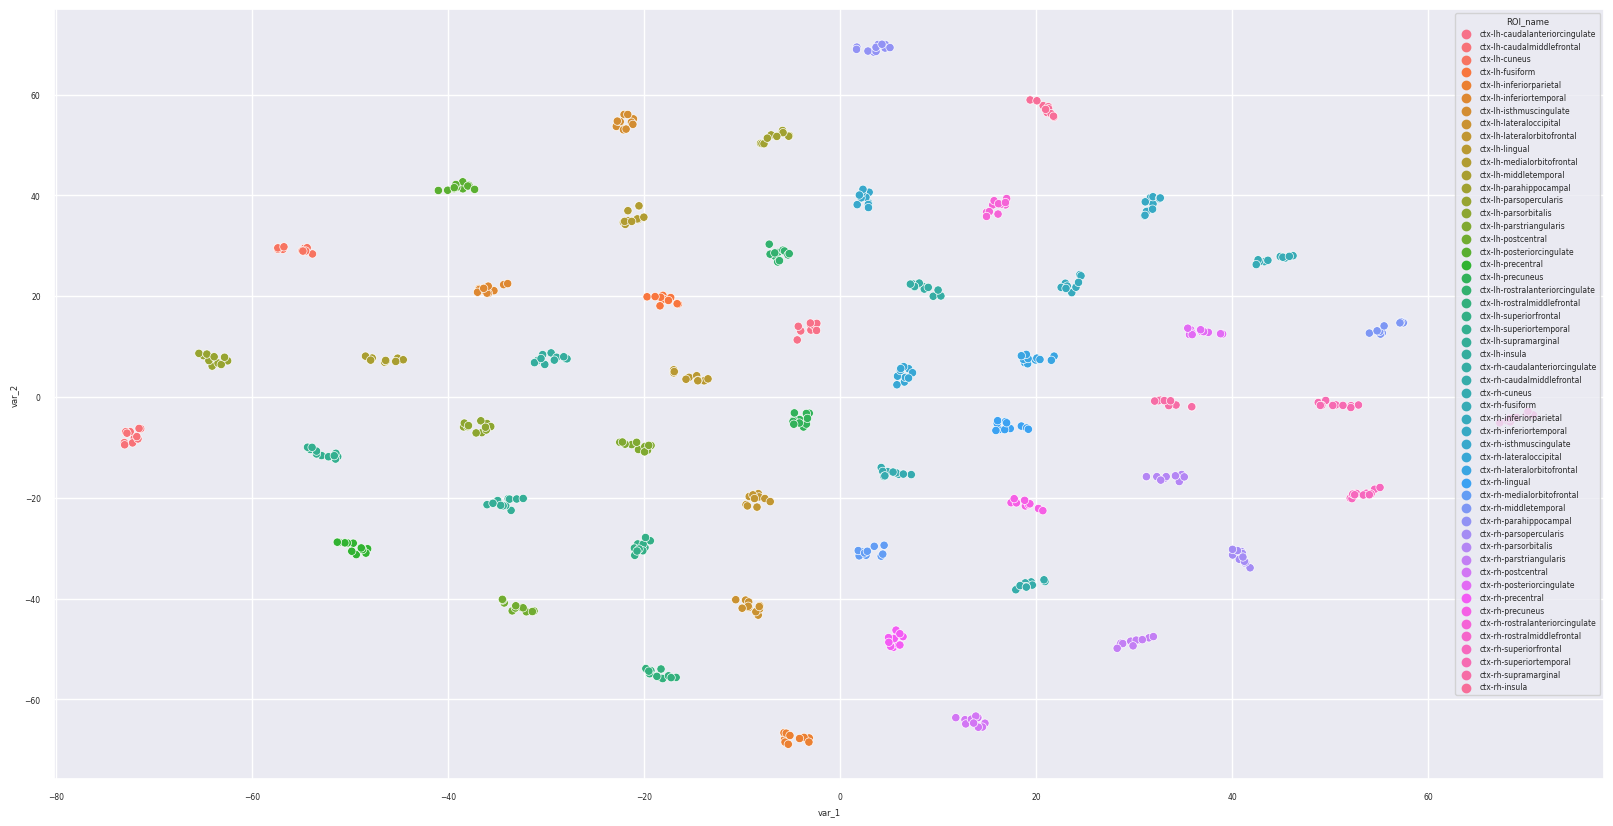

In [176]:
fig = plt.figure(figsize=(20,10))

sns.scatterplot(
    x="var_1", y="var_2",
    hue=old_subjects['ROI_name'],
    palette=sns.color_palette("husl", 52),
    color='blue',
    data=old_df_reduced,
    legend="full",
    )